## **Project: Prediction of Acute Aquatic Toxicity Toward Daphnia Magna**

- **Source:** Cassotti et al. (2014), Prediction of Acute Aquatic Toxicity Toward Daphnia magna by using the GA-kNN Method, Alternatives to Laboratory Animals Volume 42, Issue 1, March 2014
- **URL:** https://journals.sagepub.com/doi/epdf/10.1177/026119291404200106
- **Date:** 05/12/24
- **Goal:** Create a basic prediction model and a feature explainer

In [53]:
# Step 0. Load libraries and custom modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample
from sklearn.inspection import permutation_importance

def plot_results_residuals(y_pred, y_true):
    max_ypred = max(y_pred)
    max_ytrue = max(y_true)
    max_val = max(max_ypred, max_ytrue)
    resid = y_true - y_pred
    _, ax = plt.subplots(1,2)
    ax[0].scatter(x=y_pred, y=y_true, alpha=0.5, c='Teal')
    ax[0].plot([0, max_val], [0, max_val], color='Tomato')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Real')
    ax[0].set_title('Predicted vs. Real')
    ax[0].grid(True)
    ax[0].axis('square')
    ax[1].scatter(x=y_pred, y=resid, c='Teal', alpha=0.5)
    ax[1].axhline(0, linestyle='--', c='Tomato')
    ax[1].set_xlabel('Fitted values')
    ax[1].set_ylabel('Residuals')
    ax[1].set_title('Fitted values vs. Residuals')
    ax[1].grid(True)
    ax[1].axis('square')
    plt.tight_layout()
    plt.show()

# def confidence_intervals(estimators, train_data, test_data):
#     cf_estimators = {}
#     for estimator in estimators:
        
#         for i in range(50)
#         X_train_sample = resample(train_data, test_data)
#         y_train_sample =




### **1. Data loading**

**Objective:** Obtain the data from source and get a first glimpse of their properties and presentation

In [24]:
df_raw = pd.read_csv('../../data/qsar_aquatic_toxicity.csv', header=None, sep=';')
df_raw.columns = ['TPSA','SAcc','H050','MLOGP','RDCH','GATS1p','nN','C040','LC50']
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TPSA    546 non-null    float64
 1   SAcc    546 non-null    float64
 2   H050    546 non-null    int64  
 3   MLOGP   546 non-null    float64
 4   RDCH    546 non-null    float64
 5   GATS1p  546 non-null    float64
 6   nN      546 non-null    int64  
 7   C040    546 non-null    int64  
 8   LC50    546 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 38.5 KB


In [25]:
df_raw.sample(10, random_state=2024)

,TPSA,SAcc,H050,MLOGP,RDCH,GATS1p,nN,C040,LC50
55,75.27,111.456,2,0.779,2.709,1.029,2,2,2.201
5,215.34,327.629,3,0.189,4.677,1.333,0,4,6.064
339,32.67,47.536,0,3.223,2.773,0.881,2,0,4.403
350,54.37,92.973,1,3.374,3.061,0.910,0,1,3.599
436,0.00,0.000,0,2.734,1.857,0.831,0,0,3.890
203,20.23,42.683,1,1.859,1.918,0.949,0,0,3.760
458,94.88,104.618,0,4.066,3.016,1.314,3,0,7.012
46,0.00,0.000,0,3.374,2.118,1.204,0,0,3.522
44,0.00,0.000,0,3.267,2.119,1.250,0,0,4.867
38,0.00,0.000,0,5.453,2.837,0.735,0,0,6.858


### **2. Data preprocessing**

**Objectives:** Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [26]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower()
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tpsa    546 non-null    float64
 1   sacc    546 non-null    float64
 2   h050    546 non-null    int64  
 3   mlogp   546 non-null    float64
 4   rdch    546 non-null    float64
 5   gats1p  546 non-null    float64
 6   nn      546 non-null    int64  
 7   c040    546 non-null    int64  
 8   lc50    546 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 38.5 KB


### **3. Exploratory Data Analysis**

**Objective:** Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [27]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=2024)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train.shape, df_test.shape

((464, 9), (82, 9))

In [28]:
df_train.describe().T.assign(
    range =lambda x: round(x['max']-x['min'],2), 
    cv = lambda x: round(x['std']/x['mean'],2))

,count,mean,std,min,25%,50%,75%,max,range,cv
tpsa,464.0,48.848836,46.900060,0.000,17.07000,40.4600,68.37750,347.320,347.32,0.96
sacc,464.0,59.680131,68.540820,0.000,16.78600,44.1050,77.76400,571.952,571.95,1.15
h050,464.0,0.967672,1.682405,0.000,0.00000,0.0000,1.00000,18.000,18.00,1.74
mlogp,464.0,2.280711,1.729348,-6.446,1.24600,2.2480,3.33625,9.148,15.59,0.76
rdch,464.0,2.489336,0.810712,1.000,1.97500,2.3440,2.90300,6.439,5.44,0.33
gats1p,464.0,1.047978,0.403862,0.281,0.73700,1.0255,1.27625,2.500,2.22,0.39
nn,464.0,1.012931,1.432365,0.000,0.00000,1.0000,2.00000,11.000,11.00,1.41
c040,464.0,0.344828,0.808737,0.000,0.00000,0.0000,0.00000,11.000,11.00,2.35
lc50,464.0,4.639244,1.640807,0.122,3.59325,4.4980,5.56425,10.047,9.93,0.35


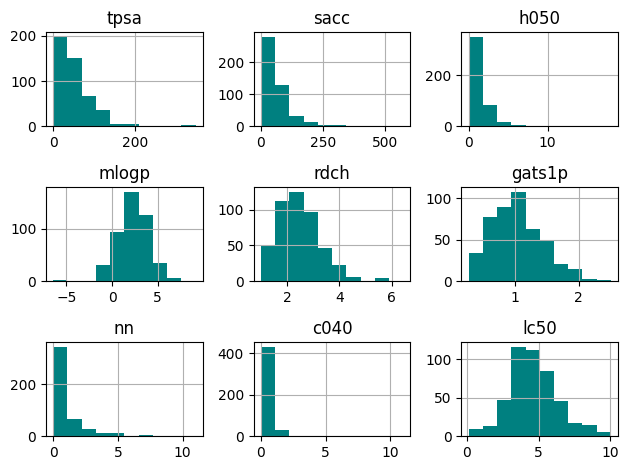

In [29]:
df_train.hist(color='teal')
plt.tight_layout()
plt.show()

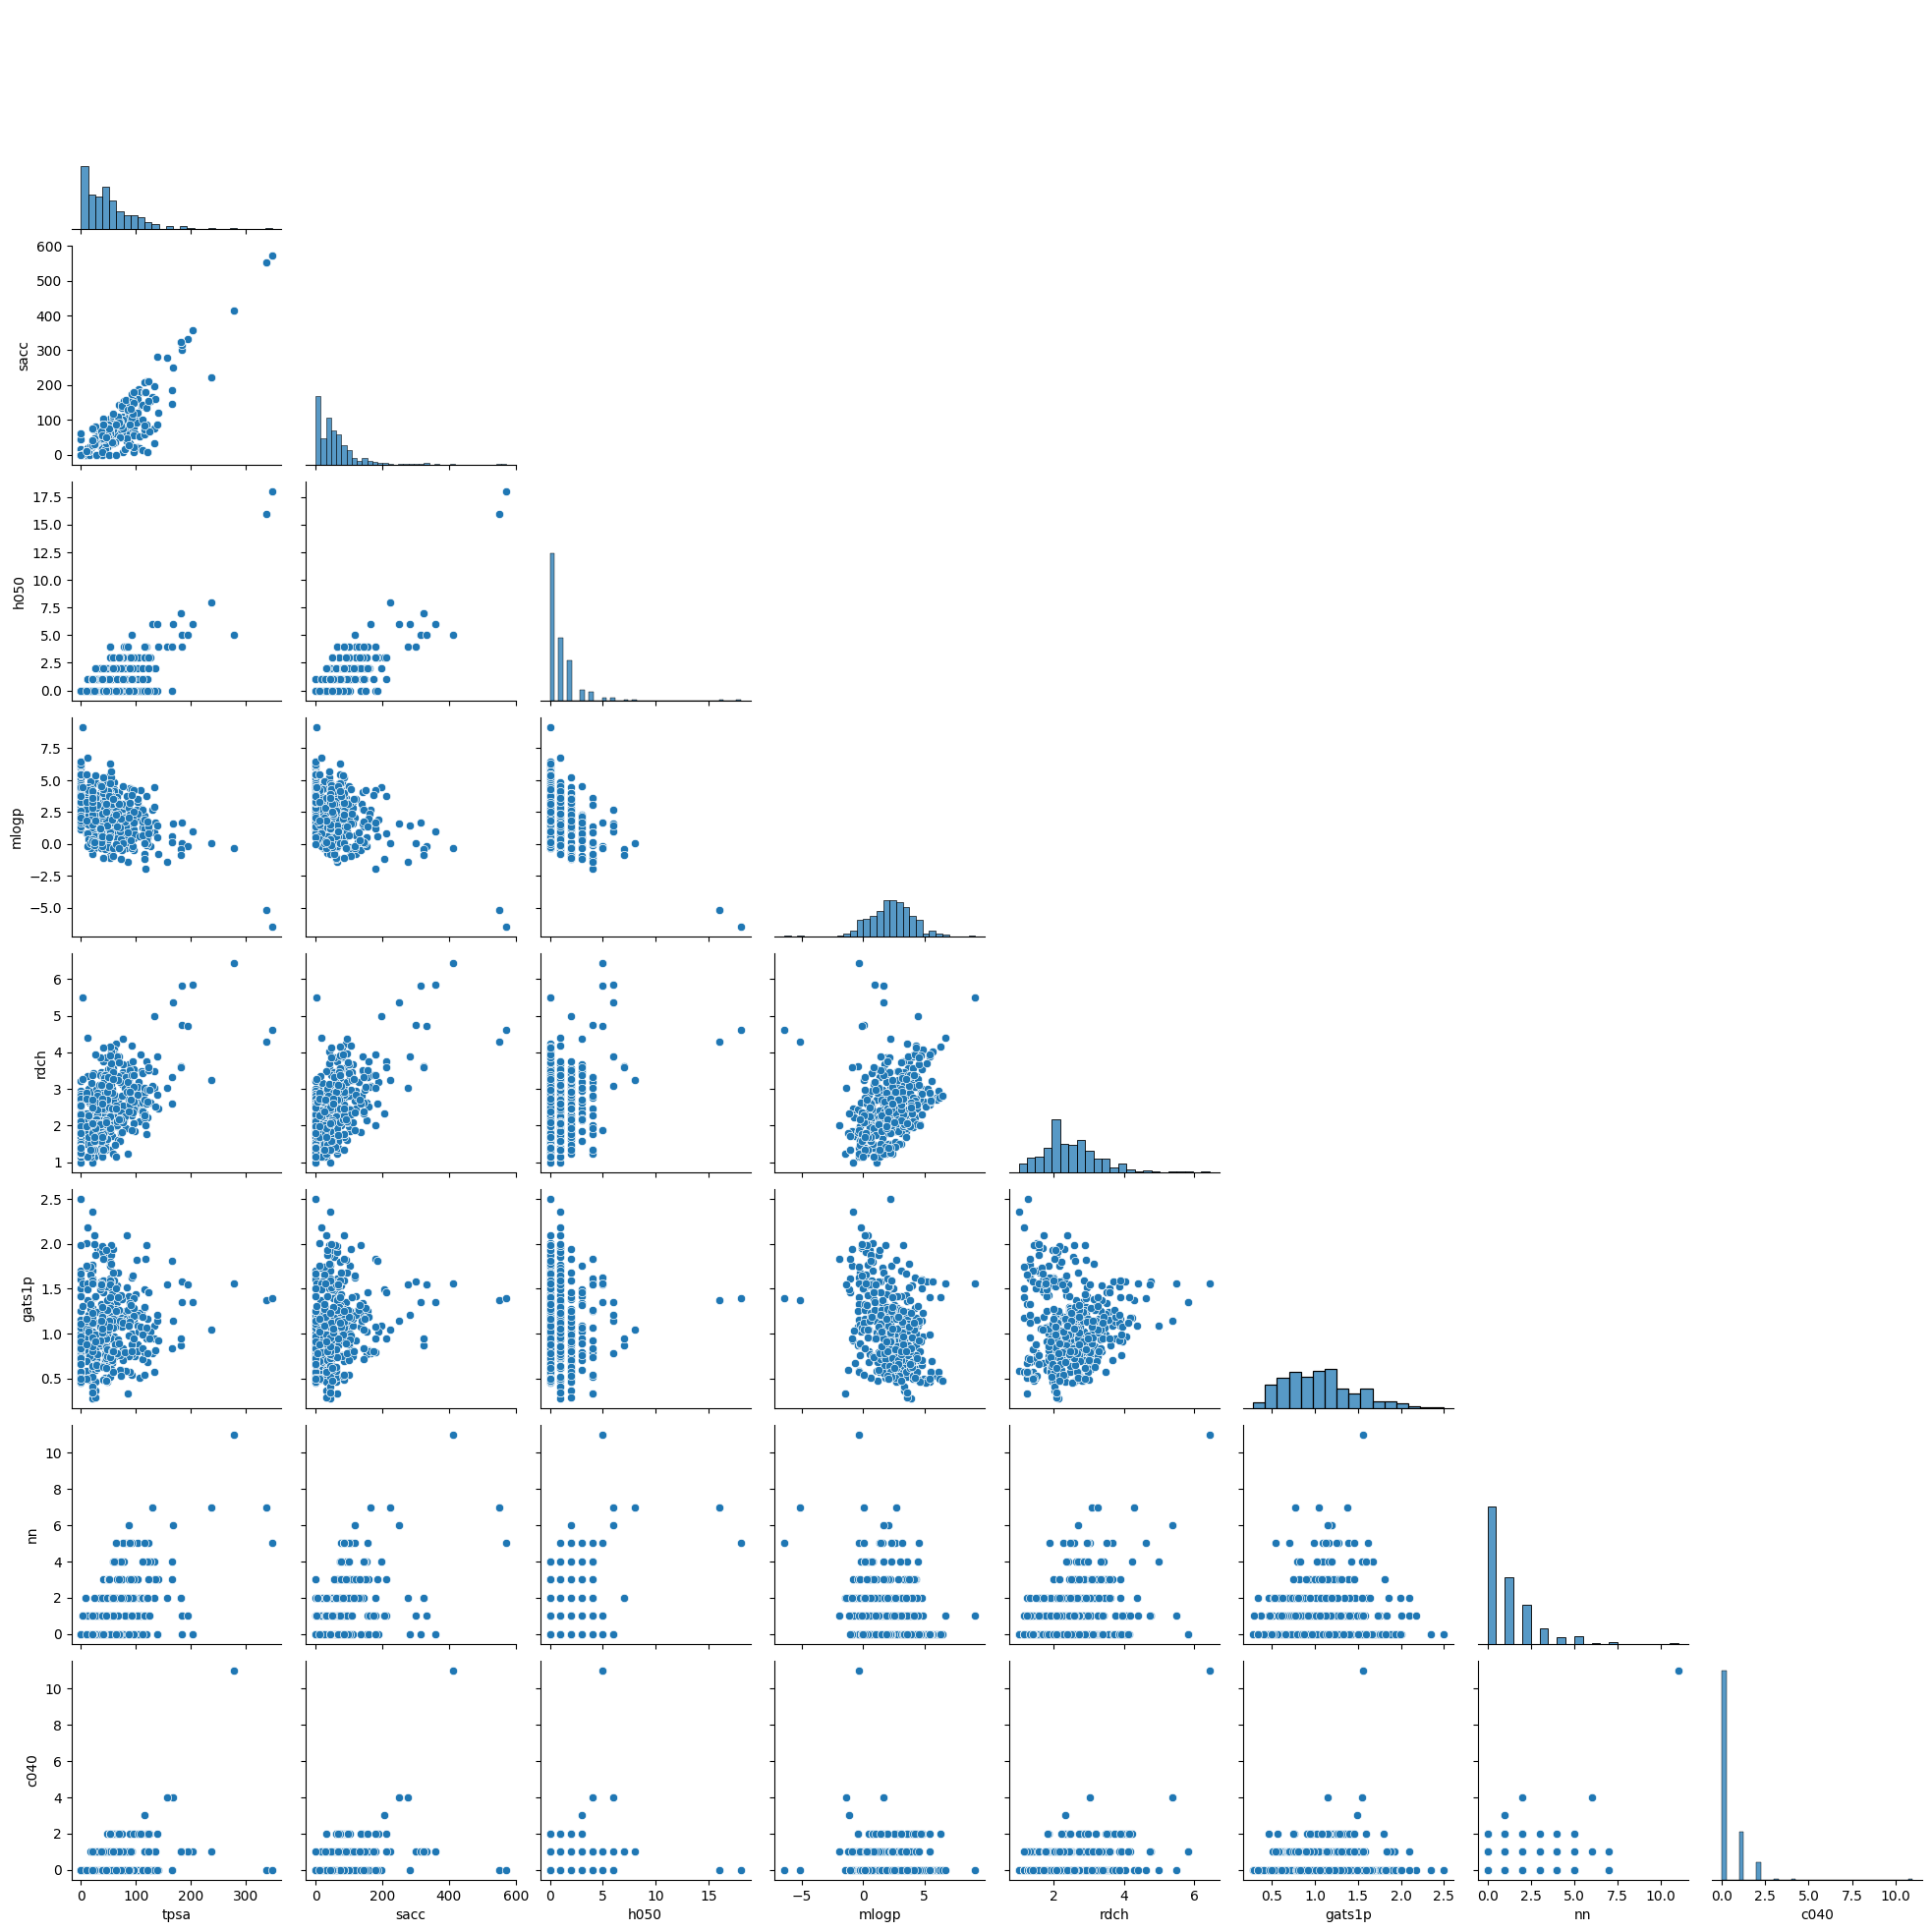

In [30]:
sns.pairplot(df_train.drop(columns=['lc50']), corner=True)
plt.show()

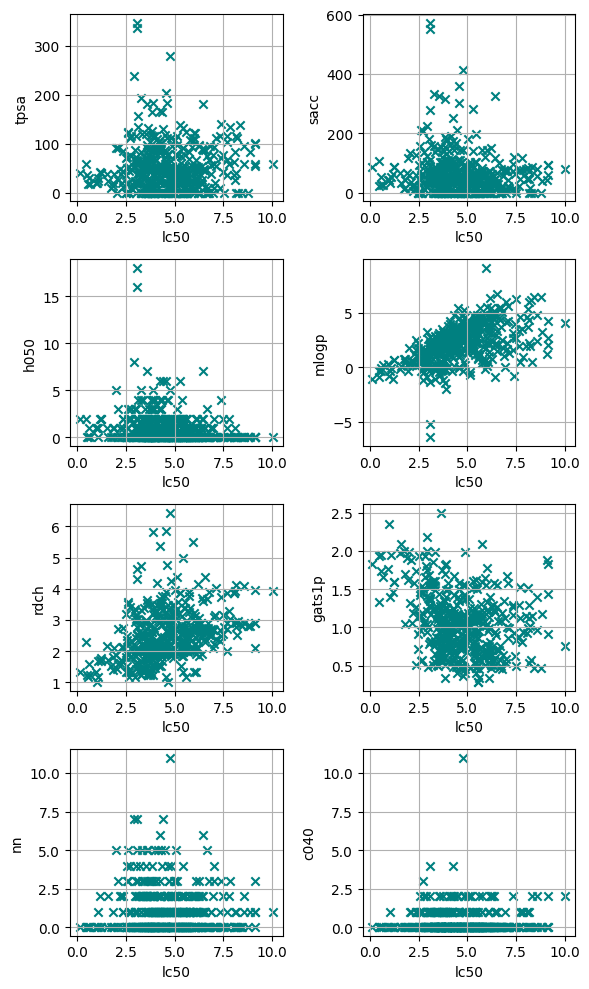

In [31]:
cols = df_train.drop(columns='lc50').columns.to_list()
fig, ax = plt.subplots(4,2, figsize=(6,10))
axes = ax.flatten()
for i, col in enumerate(cols):
    axes[i].scatter(
        df_train['lc50'], df_train[col], 
        marker='x', color='teal'
        )
    axes[i].grid(True)
    axes[i].set_xlabel('lc50')
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()

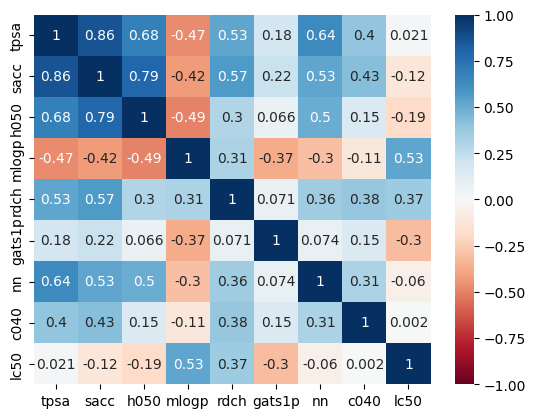

In [32]:
sns.heatmap(df_train.corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

### **4. Machine learning**

**Objective:** Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [33]:
X_train = df_train.drop(columns=['lc50'])
y_train = df_train['lc50']
X_test = df_test.drop(columns=['lc50'])
y_test = df_test['lc50']

In [46]:
reg_ridge = Pipeline([
    ('proc', RobustScaler()),
    ('ridge', Ridge())
])
reg_ridge_cv = GridSearchCV(
    reg_ridge,
    param_grid={
        'ridge__alpha':[0.01, 0.1, 1, 3, 5, 10, 100]
    },
    cv=5,
    scoring='r2'
)
reg_ridge_cv.fit(X_train, y_train)
display(reg_ridge_cv)
display(reg_ridge_cv.best_params_)
display(reg_ridge_cv.best_estimator_.named_steps['proc'].get_feature_names_out())
display(reg_ridge_cv.best_estimator_.named_steps['ridge'].coef_)

,estimator,"Pipeline(step...e', Ridge())])"
,param_grid,"{'ridge__alpha': [0.01, 0.1, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,with_centering,True


{'ridge__alpha': 10}

array(['tpsa', 'sacc', 'h050', 'mlogp', 'rdch', 'gats1p', 'nn', 'c040'],
      dtype=object)

array([ 1.13907531, -0.73501762, -0.00898004,  0.84106417,  0.4605645 ,
       -0.32475156, -0.30377955, -0.03219675])

In [35]:
y_hat_ridge = reg_ridge_cv.best_estimator_.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_hat_ridge):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_hat_ridge)):.2f}")
print(f"R2: {r2_score(y_test, y_hat_ridge):.2f}")

MSE: 1.46
RMSE: 1.21
R2: 0.55


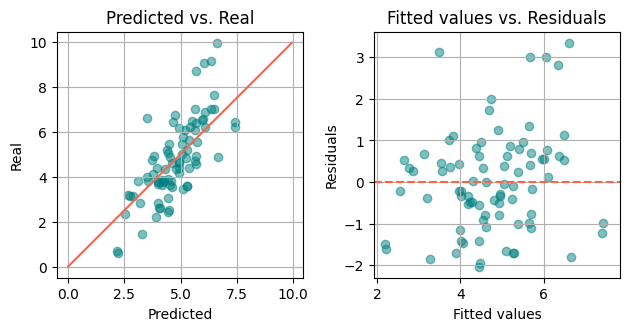

In [36]:
plot_results_residuals(y_hat_ridge, y_test)

In [48]:
reg_knn = Pipeline([
    ('proc', RobustScaler()),
    ('knn', KNeighborsRegressor())
])
reg_knn_cv = GridSearchCV(
    reg_knn,
    param_grid={
        'knn__n_neighbors':np.arange(3,31),
        'knn__weights':['uniform','distance'],
        'knn__p':[1,2]
    },
    cv=5,
    scoring='r2'
)
reg_knn_cv.fit(X_train, y_train)
display(reg_knn_cv)
display(reg_knn_cv.best_params_)

,estimator,Pipeline(step...Regressor())])
,param_grid,"{'knn__n_neighbors': array([ 3, 4..., 28, 29, 30]), 'knn__p': [1, 2], 'knn__weights': ['uniform', 'distance']}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,with_centering,True


{'knn__n_neighbors': np.int64(12), 'knn__p': 1, 'knn__weights': 'distance'}

In [49]:
y_hat_knn = reg_knn_cv.best_estimator_.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_hat_knn):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_hat_knn)):.2f}")
print(f"R2: {r2_score(y_test, y_hat_knn):.2f}")

MSE: 1.08
RMSE: 1.04
R2: 0.66


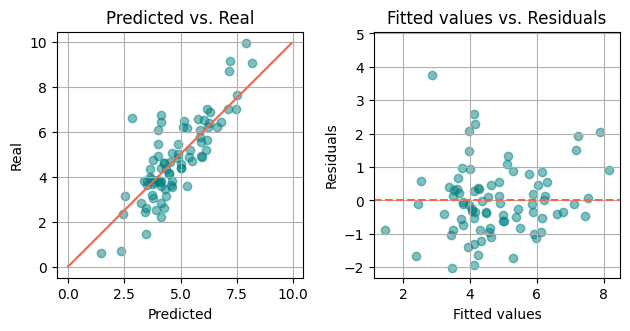

In [39]:
plot_results_residuals(y_hat_knn, y_test)

In [51]:
reg_rf = Pipeline([
    ('proc', RobustScaler()),
    ('rf', RandomForestRegressor(random_state=2024))
])
reg_rf_cv = GridSearchCV(
    reg_rf,
    param_grid={
        'rf__n_estimators':[50,100,150,200,300],
        'rf__max_depth': [2,3,4,5,6,7],
        'rf__max_features': ['sqrt','log2', None]
    },
    cv=5,
    scoring='r2'
)
reg_rf_cv.fit(X_train, y_train)
display(reg_rf_cv)
display(reg_rf_cv.best_params_)

,estimator,Pipeline(step...state=2024))])
,param_grid,"{'rf__max_depth': [2, 3, ...], 'rf__max_features': ['sqrt', 'log2', ...], 'rf__n_estimators': [50, 100, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,with_centering,True


{'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__n_estimators': 300}

In [41]:
y_hat_rf = reg_rf_cv.best_estimator_.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_hat_rf):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_hat_rf)):.2f}")
print(f"R2: {r2_score(y_test, y_hat_rf):.2f}")

MSE: 1.09
RMSE: 1.05
R2: 0.66


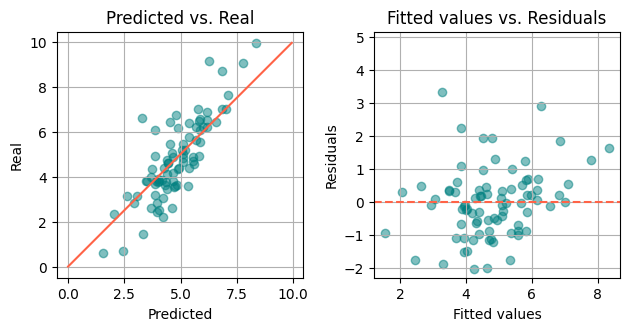

In [42]:
plot_results_residuals(y_hat_rf, y_test)

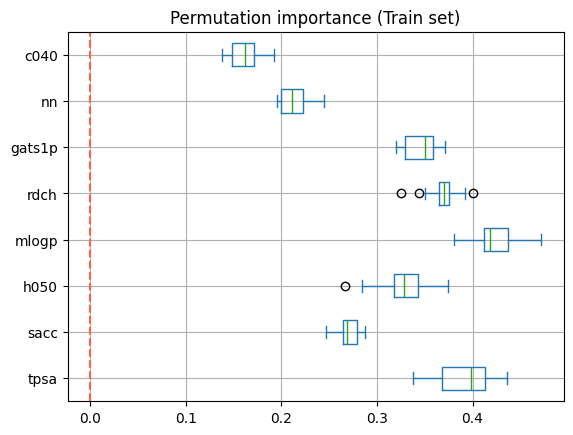

In [43]:
importance = permutation_importance(
    reg_knn_cv.best_estimator_, X_train, y_train, 
    n_repeats=25, random_state=2024
)
importance_df = pd.DataFrame(
    importance.importances.T, 
    columns=X_train.columns
)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0, color='k', linestyle='--', c='Tomato')
ax.set_title('Permutation importance (Train set)')
ax.grid(True)
plt.show()

In [ ]:
resample(X_train, y_train)